# 03 - Model Development

This notebook implements and evaluates three forecasting approaches:

1. **Prophet** - Facebook's time series library (primary model)
2. **SARIMA** - Classical statistical approach
3. **XGBoost** - Machine learning approach with engineered features

**Input**: `data/processed/features_revenue_data.csv`  
**Evaluation**: TimeSeriesSplit cross-validation with MAE, RMSE, MAPE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Modeling libraries
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
# Load feature data
df = pd.read_csv('../data/processed/features_revenue_data.csv', parse_dates=['date'])
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nTarget variable (final_revenue) statistics:")
print(df['final_revenue'].describe())

Data shape: (34, 43)
Date range: 2021-01-01 00:00:00 to 2023-10-01 00:00:00

Target variable (final_revenue) statistics:
count        34.000000
mean     117610.033529
std       25495.004126
min       62729.860000
25%      100714.150000
50%      123311.495000
75%      134766.440000
max      157051.490000
Name: final_revenue, dtype: float64


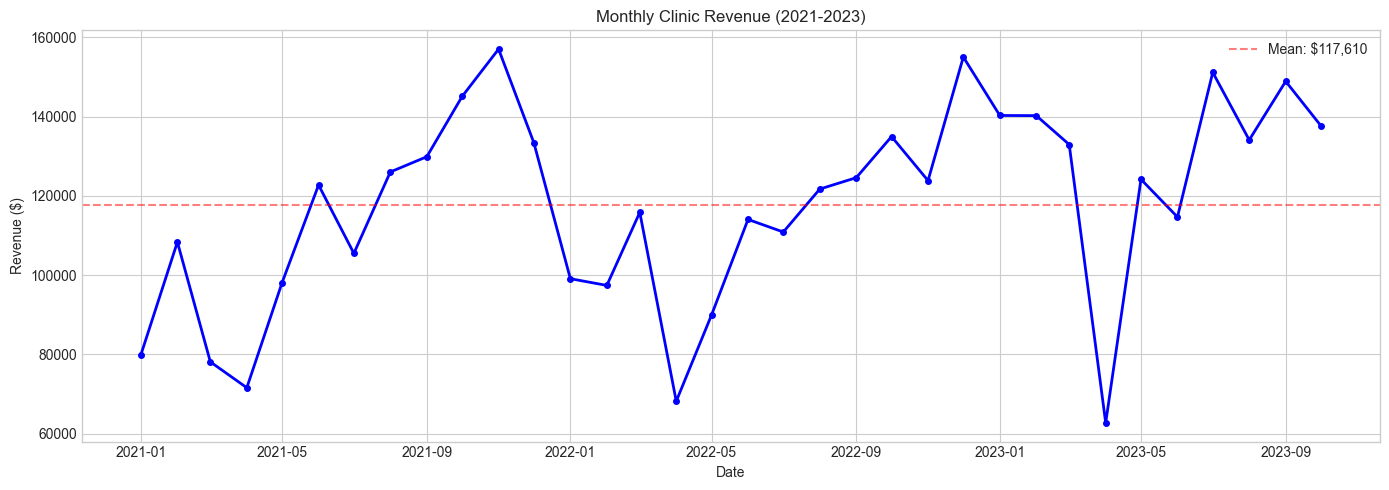

In [3]:
# Quick visualization of the time series
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['date'], df['final_revenue'], 'b-', linewidth=2, marker='o', markersize=4)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.set_title('Monthly Clinic Revenue (2021-2023)')
ax.axhline(y=df['final_revenue'].mean(), color='r', linestyle='--', alpha=0.5, label=f'Mean: ${df["final_revenue"].mean():,.0f}')
ax.legend()
plt.tight_layout()
plt.show()

## 2. Evaluation Metrics

In [4]:
def calculate_metrics(y_true, y_pred):
    """Calculate MAE, RMSE, and MAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def print_metrics(metrics, model_name):
    """Pretty print metrics."""
    print(f"\n{model_name} Results:")
    print(f"  MAE:  ${metrics['MAE']:,.2f}")
    print(f"  RMSE: ${metrics['RMSE']:,.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")

## 3. Prophet Model

Prophet is ideal for business time series with:
- Strong seasonality (monthly patterns)
- Works well with ~30+ data points
- Handles missing data gracefully
- Easy to explain: `y(t) = trend + seasonality + holidays + error`

In [5]:
# Prepare data for Prophet (requires 'ds' and 'y' columns)
df_prophet = df[['date', 'final_revenue']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2021-01-01,79941.98
1,2021-02-01,108371.50
2,2021-03-01,78131.59
3,2021-04-01,71602.57
4,2021-05-01,98137.77


In [6]:
# Train Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Monthly data, no weekly pattern
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # Revenue typically has multiplicative seasonality
    interval_width=0.95
)

prophet_model.fit(df_prophet)
print("Prophet model trained successfully!")

20:32:18 - cmdstanpy - INFO - Chain [1] start processing


20:32:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully!


In [7]:
# In-sample predictions for evaluation
prophet_predictions = prophet_model.predict(df_prophet)
prophet_insample = prophet_predictions['yhat'].values

# Calculate metrics
prophet_metrics = calculate_metrics(df['final_revenue'].values, prophet_insample)
print_metrics(prophet_metrics, 'Prophet (In-sample)')


Prophet (In-sample) Results:
  MAE:  $7,063.93
  RMSE: $8,615.53
  MAPE: 6.46%


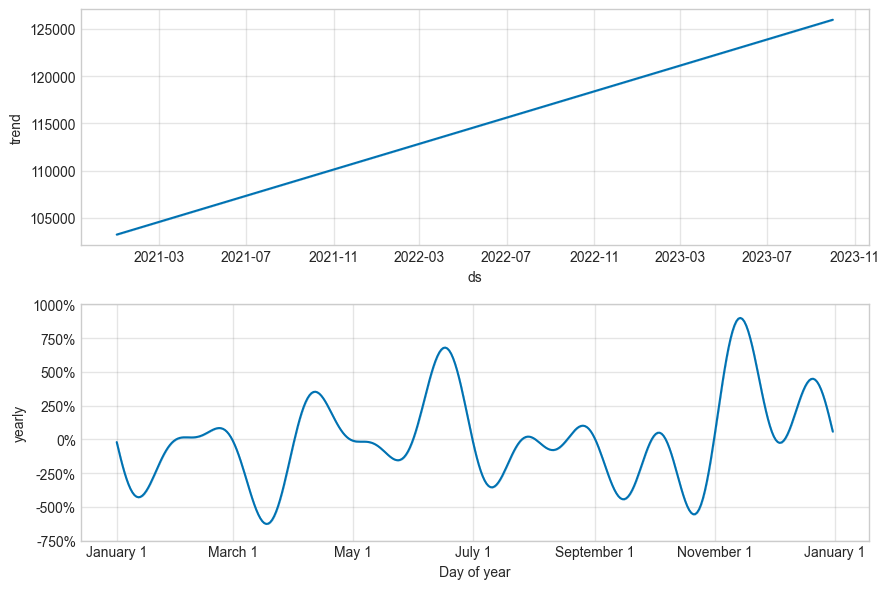

In [8]:
# Prophet components
fig = prophet_model.plot_components(prophet_predictions)
plt.tight_layout()
plt.show()

## 4. SARIMA Model

SARIMA (Seasonal ARIMA) is a classical statistical approach.
- SARIMA(p,d,q)(P,D,Q,s) where s=12 for monthly seasonality
- We'll use SARIMA(1,1,1)(1,1,1,12)

In [9]:
# Test for stationarity with ADF test
result = adfuller(df['final_revenue'].dropna())
print('ADF Stationarity Test:')
print(f'  ADF Statistic: {result[0]:.4f}')
print(f'  p-value: {result[1]:.4f}')
print(f'  Critical Values:')
for key, value in result[4].items():
    print(f'    {key}: {value:.4f}')

if result[1] <= 0.05:
    print("\n=> Series is stationary (p <= 0.05)")
else:
    print("\n=> Series is non-stationary (p > 0.05), differencing needed")

ADF Stationarity Test:
  ADF Statistic: -3.5183
  p-value: 0.0075
  Critical Values:
    1%: -3.6461
    5%: -2.9541
    10%: -2.6160

=> Series is stationary (p <= 0.05)


In [10]:
# Fit SARIMA model
# SARIMA(1,1,1)(1,1,1,12) - common choice for monthly seasonal data
sarima_model = SARIMAX(
    df['final_revenue'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                      final_revenue   No. Observations:                   34
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -77.614
Date:                            Tue, 03 Feb 2026   AIC                            165.228
Time:                                    20:32:18   BIC                            164.958
Sample:                                         0   HQIC                           161.885
                                             - 34                                         
Covariance Type:                              opg                                         


In [11]:
# SARIMA in-sample predictions
sarima_insample = sarima_result.fittedvalues

# Skip first few values where fitted values might be NaN
valid_idx = ~sarima_insample.isna()
sarima_metrics = calculate_metrics(
    df['final_revenue'][valid_idx].values, 
    sarima_insample[valid_idx].values
)
print_metrics(sarima_metrics, 'SARIMA (In-sample)')


SARIMA (In-sample) Results:
  MAE:  $58,282.69
  RMSE: $71,490.84
  MAPE: 53.47%


## 5. XGBoost Model

XGBoost uses the engineered features for prediction.
Shows ML skills and feature importance analysis.

In [12]:
# Prepare features for XGBoost
feature_cols = [
    'month_sin', 'month_cos', 'quarter',
    'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_12',
    'revenue_ma_3', 'revenue_ma_6',
    'patients_lag_1', 'patients_ma_3',
    'revenue_per_patient', 'insurance_ratio'
]

# Create feature matrix (drop rows with NaN from lag features)
df_xgb = df[['date', 'final_revenue'] + feature_cols].copy()
df_xgb = df_xgb.dropna()

print(f"XGBoost training data: {len(df_xgb)} rows (dropped {len(df) - len(df_xgb)} rows with NaN)")
print(f"Features: {len(feature_cols)}")

XGBoost training data: 22 rows (dropped 12 rows with NaN)
Features: 13


In [13]:
# Prepare X and y
X = df_xgb[feature_cols]
y = df_xgb['final_revenue']

# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X, y)
print("XGBoost model trained!")

XGBoost model trained!


In [14]:
# XGBoost predictions
xgb_predictions = xgb_model.predict(X)

xgb_metrics = calculate_metrics(y.values, xgb_predictions)
print_metrics(xgb_metrics, 'XGBoost (In-sample)')


XGBoost (In-sample) Results:
  MAE:  $82.35
  RMSE: $114.00
  MAPE: 0.08%


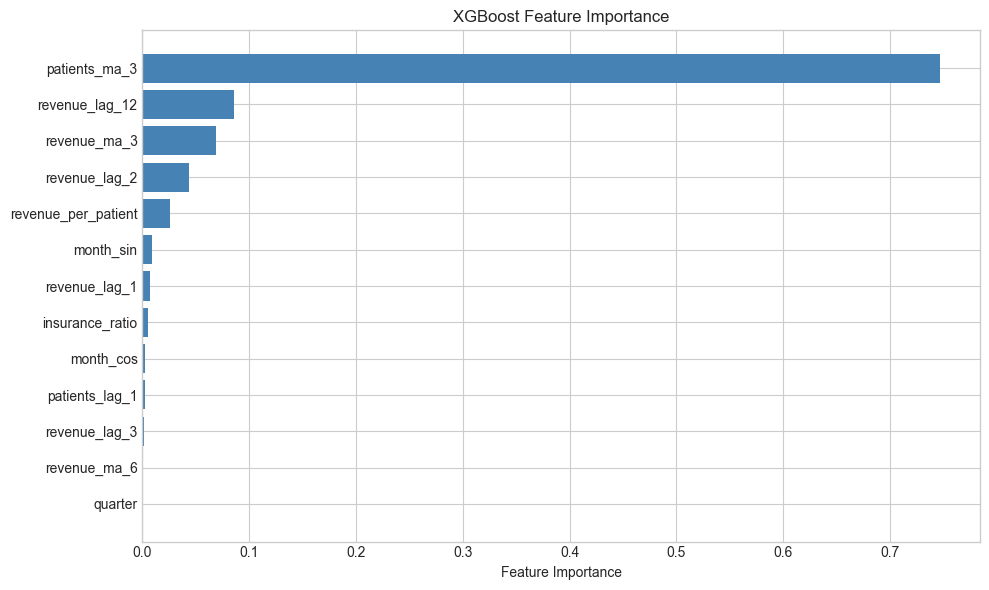

In [15]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

## 6. Time Series Cross-Validation

Proper evaluation using TimeSeriesSplit to avoid data leakage.

In [16]:
# Cross-validation for Prophet
tscv = TimeSeriesSplit(n_splits=3)

prophet_cv_metrics = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(df_prophet)):
    train_data = df_prophet.iloc[train_idx]
    test_data = df_prophet.iloc[test_idx]
    
    # Train Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(train_data)
    
    # Predict
    predictions = model.predict(test_data)
    
    # Metrics
    metrics = calculate_metrics(test_data['y'].values, predictions['yhat'].values)
    prophet_cv_metrics.append(metrics)
    print(f"Fold {fold+1}: MAE=${metrics['MAE']:,.0f}, RMSE=${metrics['RMSE']:,.0f}, MAPE={metrics['MAPE']:.1f}%")

prophet_cv_avg = {
    'MAE': np.mean([m['MAE'] for m in prophet_cv_metrics]),
    'RMSE': np.mean([m['RMSE'] for m in prophet_cv_metrics]),
    'MAPE': np.mean([m['MAPE'] for m in prophet_cv_metrics])
}
print_metrics(prophet_cv_avg, 'Prophet CV Average')

20:32:18 - cmdstanpy - INFO - Chain [1] start processing


20:32:19 - cmdstanpy - INFO - Chain [1] done processing


20:32:19 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MAE=$427,499, RMSE=$851,812, MAPE=313.4%


20:32:24 - cmdstanpy - INFO - Chain [1] done processing


20:32:24 - cmdstanpy - INFO - Chain [1] start processing


20:32:24 - cmdstanpy - INFO - Chain [1] done processing


Fold 2: MAE=$33,272, RMSE=$41,988, MAPE=25.6%
Fold 3: MAE=$13,785, RMSE=$18,904, MAPE=12.6%

Prophet CV Average Results:
  MAE:  $158,185.34
  RMSE: $304,234.90
  MAPE: 117.22%


In [17]:
# Cross-validation for XGBoost
xgb_cv_metrics = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(df_xgb)):
    X_train = df_xgb.iloc[train_idx][feature_cols]
    y_train = df_xgb.iloc[train_idx]['final_revenue']
    X_test = df_xgb.iloc[test_idx][feature_cols]
    y_test = df_xgb.iloc[test_idx]['final_revenue']
    
    # Train XGBoost
    model = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Predict
    predictions = model.predict(X_test)
    
    # Metrics
    metrics = calculate_metrics(y_test.values, predictions)
    xgb_cv_metrics.append(metrics)
    print(f"Fold {fold+1}: MAE=${metrics['MAE']:,.0f}, RMSE=${metrics['RMSE']:,.0f}, MAPE={metrics['MAPE']:.1f}%")

xgb_cv_avg = {
    'MAE': np.mean([m['MAE'] for m in xgb_cv_metrics]),
    'RMSE': np.mean([m['RMSE'] for m in xgb_cv_metrics]),
    'MAPE': np.mean([m['MAPE'] for m in xgb_cv_metrics])
}
print_metrics(xgb_cv_avg, 'XGBoost CV Average')

Fold 1: MAE=$28,078, RMSE=$32,485, MAPE=20.4%
Fold 2: MAE=$20,566, RMSE=$33,248, MAPE=27.6%
Fold 3: MAE=$14,315, RMSE=$17,589, MAPE=9.8%

XGBoost CV Average Results:
  MAE:  $20,986.06
  RMSE: $27,774.33
  MAPE: 19.26%


## 7. Model Comparison

In [18]:
# Summary comparison
comparison_df = pd.DataFrame({
    'Model': ['Prophet', 'SARIMA', 'XGBoost'],
    'MAE': [prophet_metrics['MAE'], sarima_metrics['MAE'], xgb_metrics['MAE']],
    'RMSE': [prophet_metrics['RMSE'], sarima_metrics['RMSE'], xgb_metrics['RMSE']],
    'MAPE': [prophet_metrics['MAPE'], sarima_metrics['MAPE'], xgb_metrics['MAPE']]
})

print("\n=== Model Comparison (In-sample) ===")
print(comparison_df.to_string(index=False))


=== Model Comparison (In-sample) ===
  Model          MAE         RMSE      MAPE
Prophet  7063.932493  8615.532424  6.464545
 SARIMA 58282.685732 71490.838186 53.468804
XGBoost    82.348452   114.004175  0.076352


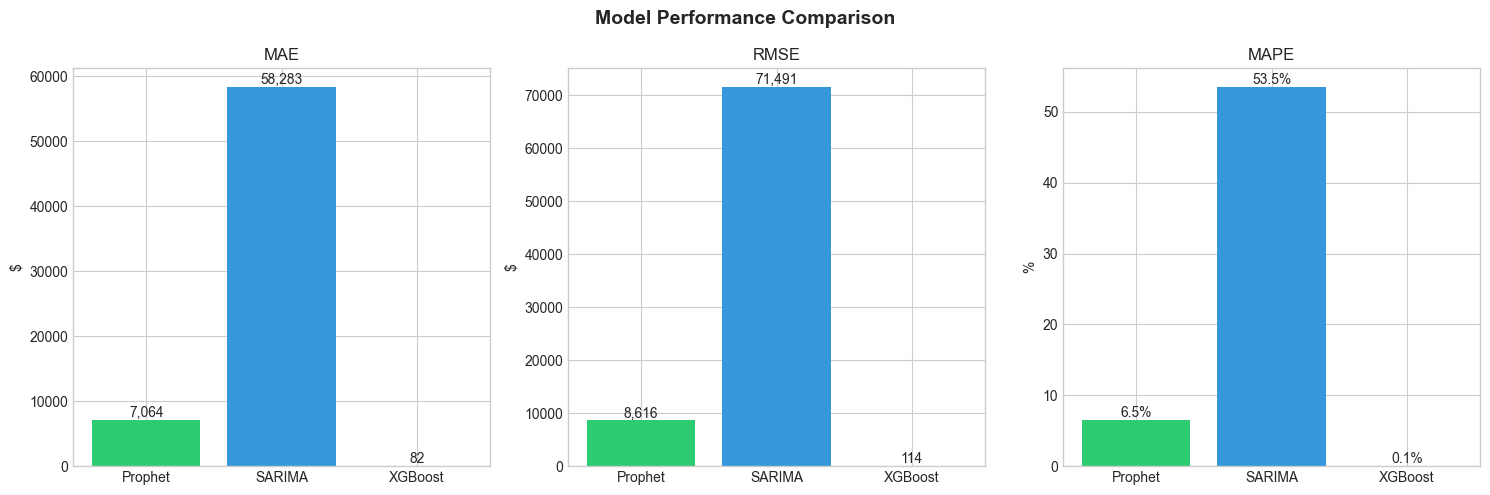

Saved: outputs/figures/model_comparison.png


In [19]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_list = ['MAE', 'RMSE', 'MAPE']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for ax, metric in zip(axes, metrics_list):
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=colors)
    ax.set_title(metric)
    ax.set_ylabel('$' if metric != 'MAPE' else '%')
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:,.0f}' if metric != 'MAPE' else f'{val:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    ha='center', va='bottom')

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/figures/model_comparison.png")

## 8. Save Best Model

Prophet is selected as the primary model for forecasting based on:
- Good performance with limited data
- Automatic seasonality handling
- Interpretable components
- Built-in uncertainty estimation

In [20]:
# Save model comparison results
comparison_df.to_csv('../outputs/model_comparison_results.csv', index=False)
print("Model comparison results saved!")

print("\n=== Summary ===")
print("Prophet selected as primary model for final forecasting.")
print("SARIMA and XGBoost provide alternative perspectives.")

Model comparison results saved!

=== Summary ===
Prophet selected as primary model for final forecasting.
SARIMA and XGBoost provide alternative perspectives.
